# Introduction

This Notebook will focus on ML modeling section of uber eats menu price prediction project

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ahmedshahriar/restaurant-menu-pricing/blob/main/notebooks/uber-eats-ML.ipynb)    [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ahmedshahriar/restaurant-menu-pricing/blob/main/notebooks/uber-eats-ML.ipynb)    [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github.com/ahmedshahriar/restaurant-menu-pricing/blob/main/notebooks/uber-eats-ML.ipynb)


Dataset -

[Uber Eats USA Data](https://www.kaggle.com/datasets/ahmedshahriarsakib/uber-eats-usa-restaurants-menus)

# Libraries

In [1]:
import ast
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (
    KFold,
    StratifiedShuffleSplit,
    cross_val_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    OneHotEncoder,
)
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from yellowbrick.regressor import ResidualsPlot

pd.set_option("display.width", None)
pd.set_option("max_colwidth", None)


warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["figure.dpi"] = 150

SEED = 33

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Ignore FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)


sns.set_style("whitegrid")  # whitegrid
sns.set_theme(style="white")

# size=25
size = 15
params = {
    "legend.fontsize": "large",
    "figure.figsize": (10, 8),
    "figure.dpi": 150,
    "axes.labelsize": size,
    "axes.titlesize": size,
    "xtick.labelsize": size * 0.75,
    "ytick.labelsize": size * 0.75,
    "axes.titlepad": 25,
}
plt.rcParams.update(params)

In [ ]:
df_sampled = pd.read_csv("datasets/sampled-final-data.csv")
df_sampled["ingredients"] = df_sampled["ingredients"].apply(ast.literal_eval)
df = df_sampled.copy()
df.reset_index(drop=True, inplace=True)

In [ ]:
df_sampled[["price", "density", "cost_of_living_index"]].corr()["price"]

In [3]:
df_sampled.shape

(42710, 8)

In [4]:
df_sampled.head()

,price_range,state_id,city,density,category,price,ingredients,cost_of_living_index
0,cheap,Wisconsin,appleton,1156.0,Salads,12.90,"[3-cheese blend, romaine lettuce, pico de gallo, meat, tomato salsa, tortilla strips, pinto beans]",49.94
1,cheap,Wisconsin,appleton,1156.0,Salads,11.05,"[chile corn salsa, black beans, adobo chicken, romaine lettuce, citrus lime vinaigrette, pico de gallo, tortilla strips]",49.94
2,moderate,Wisconsin,appleton,1156.0,Salads,7.14,"[cheddar cheese, lettuce, crackers, carrots, iced tomatoes]",49.94
3,moderate,Wisconsin,appleton,1156.0,Salads,8.24,"[diced eggs, diced ham, cheddar cheese, lettuce, diced tomatoes, crackers, bacon, carrots]",49.94
4,moderate,Wisconsin,appleton,1156.0,Salads,8.24,"[cheddar cheese, lettuce, fajita chicken, diced tomatoes, crackers, carrots]",49.94


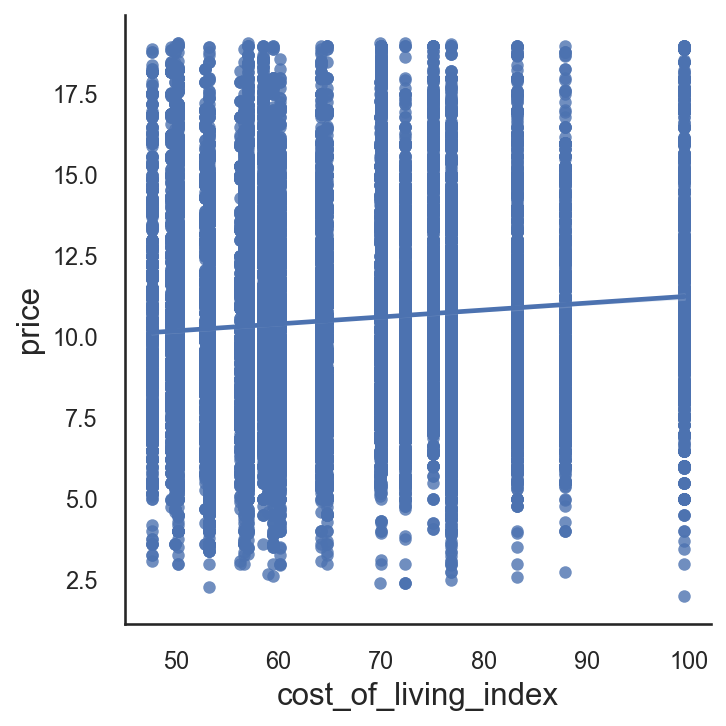

In [8]:
sns.lmplot(data=df_sampled, x="cost_of_living_index", y="price");

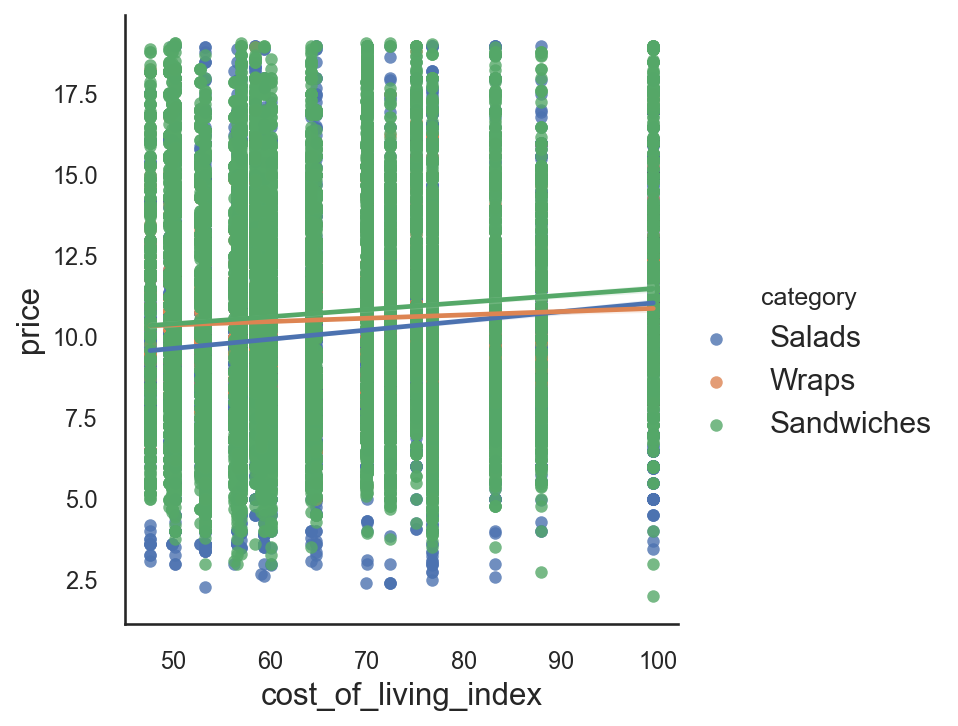

In [7]:
sns.lmplot(data=df_sampled, x="cost_of_living_index", y="price", hue="category");

# Data Preparation

In [12]:
# train test split
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_index, test_index in strat_split.split(df, df["category"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

# train Dataset
X_train = strat_train_set.loc[:, strat_train_set.columns != "price"].copy()
y_train = strat_train_set["price"].copy()

# test dataset
X_test = strat_test_set.loc[:, strat_test_set.columns != "price"].copy()
y_test = strat_test_set["price"].values


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((34168, 7), (34168,), (8542, 7), (8542,))

# Pipeline

In [ ]:
# some notes about the modeling

# Countvectorizer performed better with small sets, but for higher dimension TF-IDF performed better
# Consider TF-idf since it performed better than Count Vectorization

# randomforest
# TF-IDF with all features/tokens, 2.515568243667373
# TF-IDF with all features/tokens, min_df=3, 2.5304699119648215
# TF-IDF with all features/tokens, max_features=3500, 2.5144308044053023
# TF-IDF with all features/tokens, max_features=3000, 2.517139953439159
# count, all, 2.522429940939127

# xgboost
# count
# default param, 2.5178922113964095
# basic tuning 2.4922569758802595
# further tuning 2.486425893801829 (tree 1000)
# tf-idf
# further tuning 2.4633462844924496 (tree 1000)

# without city
# RMSE:  2.469137223560531
# city doesn't provide much weights to model

In [14]:
%%time

numerical_columns = ["cost_of_living_index", "density"]  # cost_of_living_index density
numerical_transformer = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
    ]
)

# tax varies in states so keeping the state_id
# "city" is discarded, since it doesn't improve the model that much

categorical_columns = ["category", "price_range", "state_id"]
categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

text_columns = ["ingredients"]

# apply Tf-IDF on the tokenized ingredients
# https://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/


def dummy_fun(doc):
    return doc


text_transformer = Pipeline(
    steps=[
        ("squeez", FunctionTransformer(lambda x: x.squeeze())),  # squeezing dimension from (X,1) to (X,)
        (
            "vec",
            TfidfVectorizer(
                analyzer="word",  # CountVectorizer TfidfVectorizer
                tokenizer=dummy_fun,
                preprocessor=dummy_fun,
                token_pattern=None,
                max_features=None,
            ),
        ),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical_transformers", numerical_transformer, numerical_columns),
        ("categorical_transformers", categorical_transformer, categorical_columns),
        ("text_transformers", text_transformer, text_columns),
    ],
    n_jobs=-1,
)

CPU times: user 61 µs, sys: 627 µs, total: 688 µs
Wall time: 2.11 ms


# Model Building

## Linear Regression

In [15]:
lr_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", LinearRegression(n_jobs=-1))])

## Decision Tree

### Hyperparameter Tuning

In [72]:
def objective(trial):
    # Define the hyperparameter search space
    max_depth = trial.suggest_int("max_depth", 2, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    random_state = trial.suggest_categorical("random_state", [SEED])

    # Create the DecisionTreeRegressor with the suggested hyperparameters
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state,
    )

    # Create the pipeline with StandardScaler and DecisionTreeRegressor
    pipeline = Pipeline([("preprocessing", preprocessor), ("regressor", model)])

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = pipeline.predict(X_test)

    # Calculate the mean squared error for the prediction
    mse = mean_squared_error(y_test, y_pred, squared=False)

    return mse

In [73]:
# Create the Optuna study
study = optuna.create_study(direction="minimize")

# Optimize the study using the objective function
study.optimize(objective, n_trials=100)

# Get the best hyperparameters and corresponding MSE
best_params = study.best_params
best_mse = study.best_value
print(f"Best DecisionTreeRegressor score: {best_mse},  Best params {best_params}")

[I 2023-07-31 20:14:39,912] A new study created in memory with name: no-name-dbbd0fe5-d36e-495e-884e-ca3488ea8b08
[I 2023-07-31 20:14:40,242] Trial 0 finished with value: 2.8974884938370105 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 33}. Best is trial 0 with value: 2.8974884938370105.
[I 2023-07-31 20:14:40,741] Trial 1 finished with value: 2.8974884938370105 and parameters: {'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 3, 'random_state': 33}. Best is trial 0 with value: 2.8974884938370105.
[I 2023-07-31 20:14:41,171] Trial 2 finished with value: 2.7572903619289404 and parameters: {'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 9, 'random_state': 33}. Best is trial 2 with value: 2.7572903619289404.
[I 2023-07-31 20:14:41,528] Trial 3 finished with value: 2.804937456158982 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 2, 'random_state': 33}. Best is trial 2 with value: 2.757

Best DecisionTreeRegressor score: 2.7185322838424293,  Best params {'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 10, 'random_state': 33}


In [74]:
tree_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", DecisionTreeRegressor(**best_params))])

## Random Forest

### Hyperparameter Tuning

In [65]:
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 50, 1000, step=50)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    random_state = trial.suggest_categorical("random_state", [SEED])

    # Create the DecisionTreeRegressor with the suggested hyperparameters
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=-1)

    # Create the pipeline with StandardScaler and DecisionTreeRegressor
    pipeline = Pipeline([("preprocessing", preprocessor), ("regressor", model)])

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = pipeline.predict(X_test)

    # Calculate the mean squared error for the prediction
    mse = mean_squared_error(y_test, y_pred, squared=False)

    return mse

In [66]:
# Create the Optuna study
study = optuna.create_study(direction="minimize")

# Optimize the study using the objective function
study.optimize(objective, n_trials=100)

# Get the best hyperparameters and corresponding MSE
best_params = study.best_params
best_mse = study.best_value
print(f"Best RandomForestRegressor score: {best_mse},  Best params {best_params}")

[I 2023-07-31 19:33:16,395] A new study created in memory with name: no-name-2ae3147a-77a0-4354-87ce-401da9d486ea
[I 2023-07-31 19:33:23,433] Trial 0 finished with value: 2.8494714175015496 and parameters: {'n_estimators': 850, 'max_depth': 4, 'random_state': 33}. Best is trial 0 with value: 2.8494714175015496.
[I 2023-07-31 19:33:37,466] Trial 1 finished with value: 2.6532240967623943 and parameters: {'n_estimators': 550, 'max_depth': 11, 'random_state': 33}. Best is trial 1 with value: 2.6532240967623943.
[I 2023-07-31 19:34:14,129] Trial 2 finished with value: 2.5973073761586987 and parameters: {'n_estimators': 900, 'max_depth': 15, 'random_state': 33}. Best is trial 2 with value: 2.5973073761586987.
[I 2023-07-31 19:34:41,390] Trial 3 finished with value: 2.597424737612449 and parameters: {'n_estimators': 650, 'max_depth': 15, 'random_state': 33}. Best is trial 2 with value: 2.5973073761586987.
[I 2023-07-31 19:34:47,254] Trial 4 finished with value: 2.611490331580883 and parameter

Best RandomForestRegressor score: 2.5971361620509232,  Best params {'n_estimators': 1000, 'max_depth': 15, 'random_state': 33}


In [69]:
rf_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", RandomForestRegressor(n_jobs=-1, **best_params))]
)

## XGBoost Regressor

### Hyperparameter Tuning

In [75]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1500, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
        "random_state": trial.suggest_categorical("random_state", [SEED]),
    }

    model = XGBRegressor(**params, n_jobs=-1)

    # Create the pipeline with StandardScaler and DecisionTreeRegressor
    pipeline = Pipeline([("preprocessing", preprocessor), ("regressor", model)])

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = pipeline.predict(X_test)

    # Calculate the mean squared error for the prediction
    mse = mean_squared_error(y_test, y_pred, squared=False)

    return mse

In [76]:
# Create the Optuna study
study = optuna.create_study(direction="minimize")

# Optimize the study using the objective function
study.optimize(objective, n_trials=100)

# Get the best hyperparameters and corresponding MSE
best_params = study.best_params
best_mse = study.best_value
print(f"Best XGBoost score: {best_mse},  Best params {best_params}")

[I 2023-07-31 20:15:24,617] A new study created in memory with name: no-name-8a6c4a18-12e1-42e3-80b7-df61ceac6db1
[I 2023-07-31 20:15:44,047] Trial 0 finished with value: 2.4867847034676145 and parameters: {'n_estimators': 1300, 'max_depth': 6, 'learning_rate': 0.02470086482784351, 'random_state': 33}. Best is trial 0 with value: 2.4867847034676145.
[I 2023-07-31 20:16:28,870] Trial 1 finished with value: 2.5189769469620917 and parameters: {'n_estimators': 850, 'max_depth': 15, 'learning_rate': 0.004695569533351968, 'random_state': 33}. Best is trial 0 with value: 2.4867847034676145.
[I 2023-07-31 20:17:05,008] Trial 2 finished with value: 2.45791923857796 and parameters: {'n_estimators': 1500, 'max_depth': 11, 'learning_rate': 0.06437883819615615, 'random_state': 33}. Best is trial 2 with value: 2.45791923857796.
[I 2023-07-31 20:17:26,222] Trial 3 finished with value: 2.4924197634395004 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.01221684526964657, 'rand

Best XGBoost score: 2.4545853127024904,  Best params {'n_estimators': 1100, 'max_depth': 8, 'learning_rate': 0.09988647193104266, 'random_state': 33}


In [77]:
xgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "model",
            XGBRegressor(
                n_jobs=-1,
                **best_params,
                # tree_method='gpu_hist',
                # gpu_id=0,
                # random_state=SEED
            ),
        ),
    ]
)

## Model Evaluation

Model Evaluation :



>lr, cross-validation score - mean  : 2.659 std: (0.171)

Test Scores: 

MAE: 1.9442
MSE: 6.8218
RMSE: 2.6119
R^2: 0.2623



>tree, cross-validation score - mean  : 2.725 std: (0.099)

Test Scores: 

MAE: 2.1298
MSE: 7.3904
RMSE: 2.7185
R^2: 0.2008



>rforest, cross-validation score - mean  : 2.584 std: (0.112)

Test Scores: 

MAE: 2.0151
MSE: 6.7451
RMSE: 2.5971
R^2: 0.2706



>xgb, cross-validation score - mean  : 2.446 std: (0.129)

Test Scores: 

MAE: 1.8229
MSE: 6.0250
RMSE: 2.4546
R^2: 0.3485


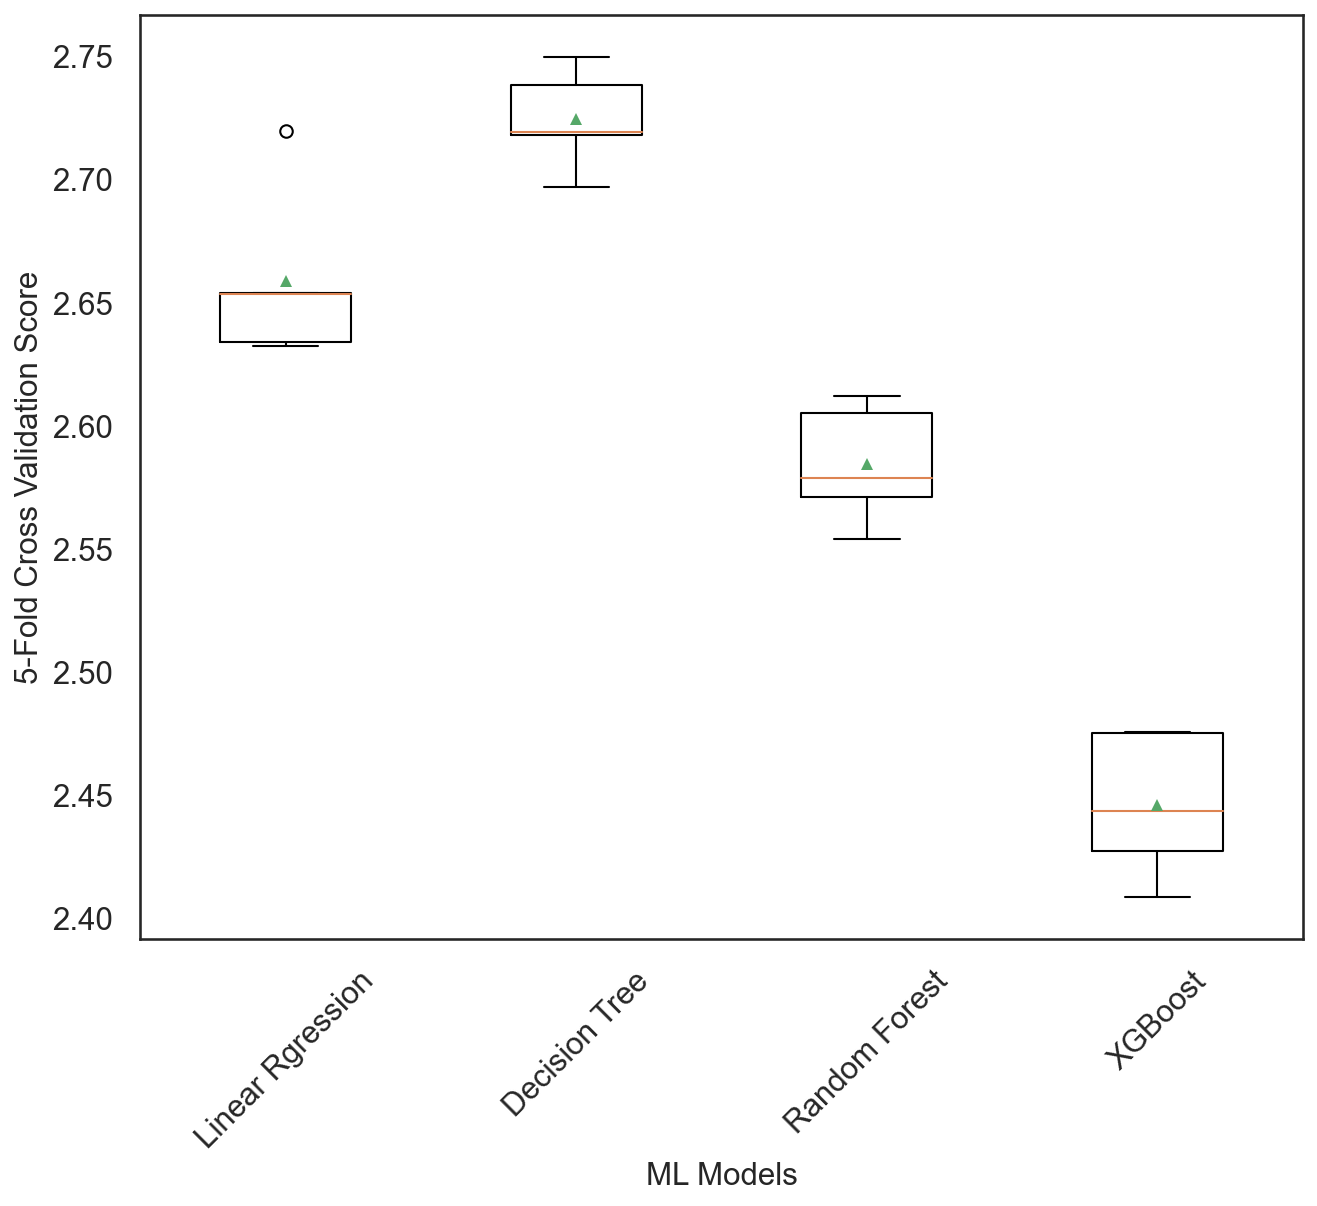

CPU times: user 5min 52s, sys: 7.26 s, total: 5min 59s
Wall time: 5min 21s


In [78]:
%%time


# get a list of models to evaluate
def get_models():
    models = dict()
    models["lr"] = lr_pipeline
    models["tree"] = tree_pipeline
    models["rforest"] = rf_pipeline
    models["xgb"] = xgb_pipeline
    return models


# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=SEED).get_n_splits(X.values)
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf, n_jobs=-1, error_score="raise")
    return scores


# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()

print("Model Evaluation :")

for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    reg_rmse_scores = np.sqrt(-scores)
    results.append(reg_rmse_scores)
    names.append(name)
    print("\n\n")
    print(f">{name}, cross-validation score - mean  : {np.mean(reg_rmse_scores):.3f} std: ({np.std(scores):.3f})")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("\nTest Scores: \n")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
    print(f"R^2: {r2_score(y_test, y_pred):.4f}")

# plot model performance for comparison
font_size = 15
plt.figure(figsize=(10, 8))
plt.boxplot(results, labels=names, showmeans=True)

# plt.title("Price Prediction Model Performance",  fontsize=font_size)
plt.xlabel("ML Models", fontsize=font_size)
plt.ylabel("5-Fold Cross Validation RMSE Score", fontsize=font_size)
plt.xticks(
    ticks=[1, 2, 3, 4],
    labels=["Linear Rgression", "Decision Tree", "Random Forest", "XGBoost"],
    fontsize=font_size,
    rotation=45,
)
plt.yticks(fontsize=font_size)
# plt.legend()
plt.show()

# Model Evaluation :
# >lr, cross-validation score - mean  : 2.659 std: (0.171)
# MAE: 1.9442
# MSE: 6.8218
# RMSE: 2.6119
# R^2: 0.2623
# >tree, cross-validation score - mean  : 2.677 std: (0.131)
# MAE: 1.9135
# MSE: 7.2107
# RMSE: 2.6853
# R^2: 0.2202
# >rforest, cross-validation score - mean  : 2.507 std: (0.098)
# MAE: 1.8353
# MSE: 6.2778
# RMSE: 2.5056
# R^2: 0.3211
# >xgb, cross-validation score - mean  : 2.480 std: (0.121)
# MAE: 1.8941
# MSE: 6.2354
# RMSE: 2.4971
# R^2: 0.3257

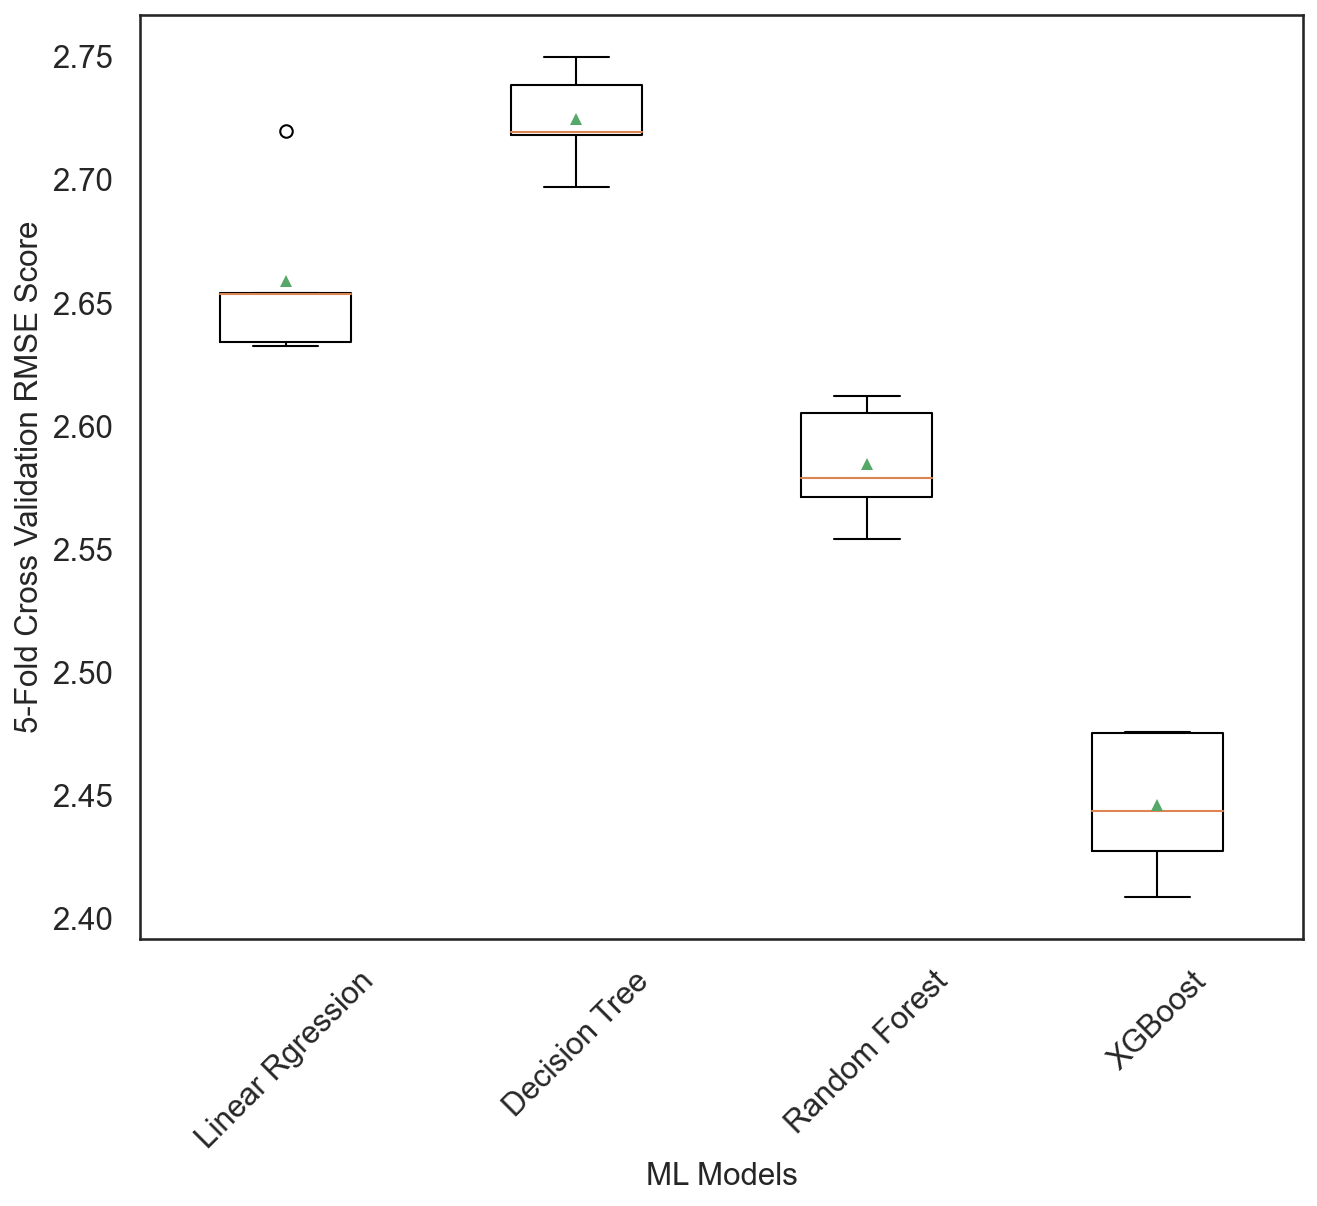

In [80]:
font_size = 15
plt.figure(figsize=(10, 8))
plt.boxplot(results, labels=names, showmeans=True)

# plt.title("Price Prediction Model Performance",  fontsize=font_size)
plt.xlabel("ML Models", fontsize=font_size)
plt.ylabel("5-Fold Cross Validation RMSE Score", fontsize=font_size)
plt.xticks(
    ticks=[1, 2, 3, 4],
    labels=["Linear Rgression", "Decision Tree", "Random Forest", "XGBoost"],
    fontsize=font_size,
    rotation=45,
)
plt.yticks(fontsize=font_size)
# plt.legend()
plt.show()

## XGBoost Evaluation

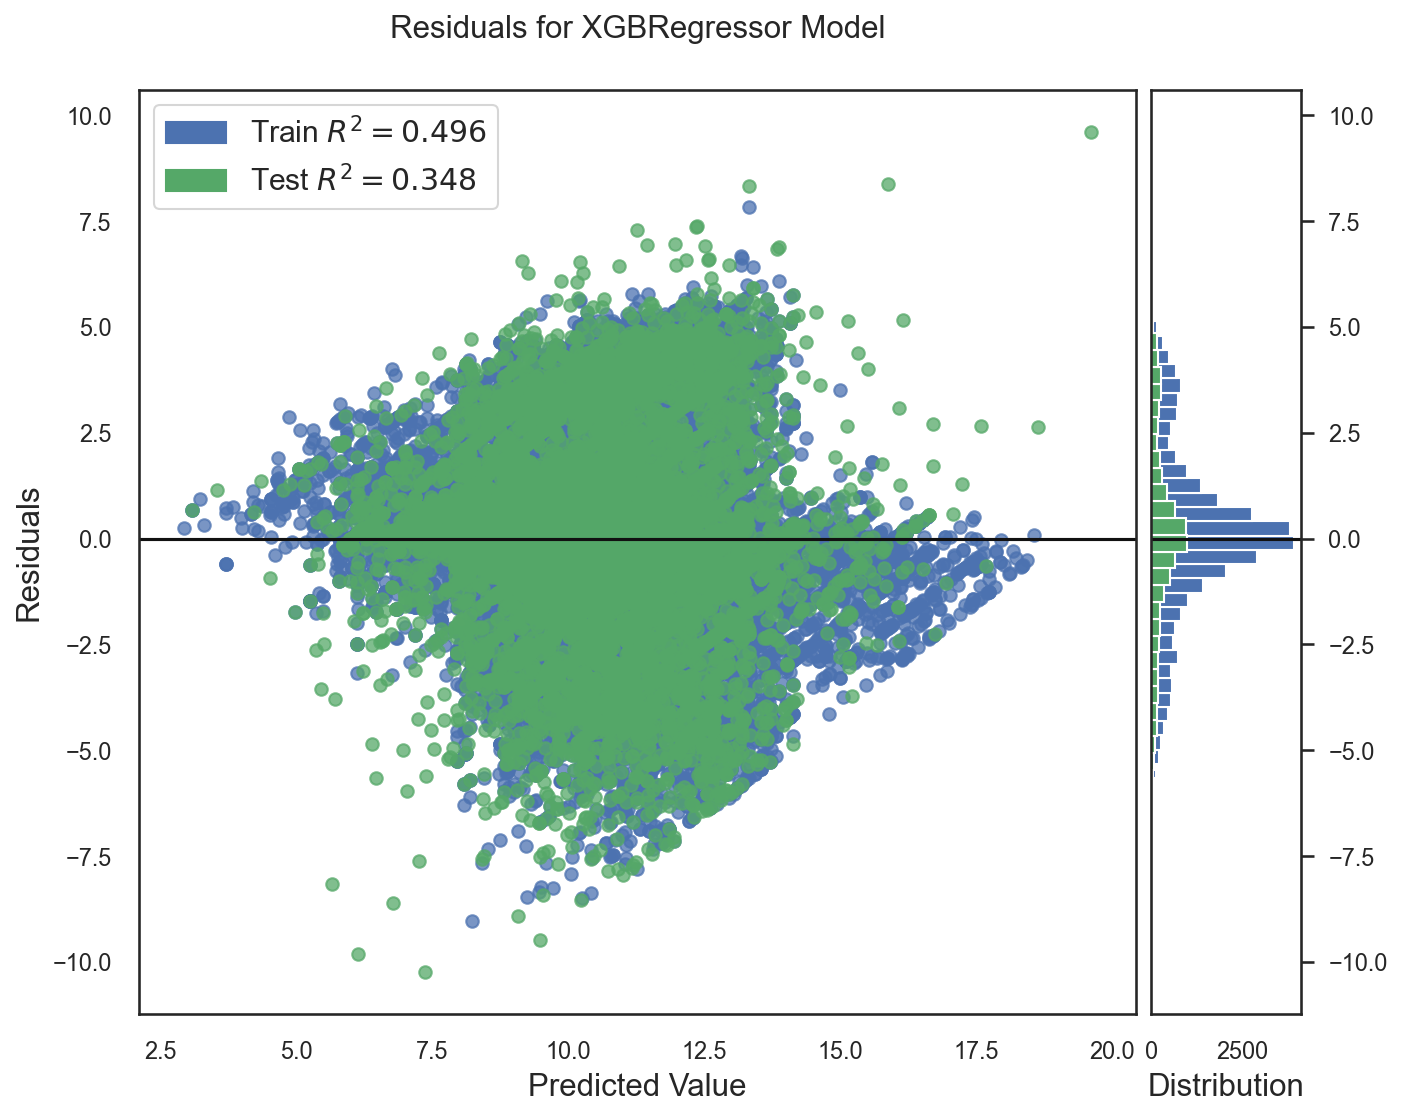

In [85]:
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(xgb_pipeline)  # hist=False, qqplot=True

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();